<a href="https://colab.research.google.com/github/Zaxis018/efficientnet_object_detection/blob/main/object_detector_from_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install imutils

In [10]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.transforms.functional as F
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
import time
import argparse

In [12]:
model = torch.load('efficientnetv2.pth')
model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): Hardswish()
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2):

In [13]:
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", default = "./cat_dog.jpg", #required=False,
    help="path to the input image")
ap.add_argument("-s", "--size", type=str, default="(200, 150)",
    help="ROI size (in pixels)")
ap.add_argument("-c", "--min-conf", type=float, default=0.7,
    help="minimum probability to filter weak detections")
ap.add_argument("-v", "--visualize", type=int, default=1,
    help="whether or not to show extra visualizations for debugging")
args = vars(ap.parse_args([]))

In [14]:
def cv2_to_tensor(image):
    image = F.to_tensor(image)
    image = F.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return image.unsqueeze(0)
image = cv2.imread(args["image"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

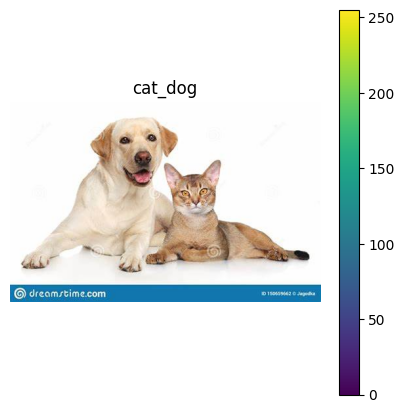

In [15]:
# Display image
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.set_title("cat_dog")
plt.imshow(image)
plt.axis("off")
plt.colorbar()

In [16]:
WIDTH = 600 #
PYR_SCALE = 1.5
WIN_STEP = 16*3 # running on laptop so I generated a small pyramid
ROI_SIZE = eval(args["size"])
INPUT_SIZE = (224, 224) #input size for efficientnet_model

In [17]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image, this is the base of the image pyramid
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        #scale controls how much the image is resized at each layer
        w = int(image.shape[1] / scale)
        # resize the image and take care of image aspect-ratio
        image = imutils.resize(image, width=w)
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

In [18]:
orig = image
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
rois = []
locs = []
start = time.time()
tot_images = 0


In [19]:
def sliding_window_pytorch(image, step, ws):
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])


In [20]:
for p, image in enumerate(pyramid):
    scale = W / float(image.shape[1])
    sw = 0
    for (x, y, roiOrig) in sliding_window_pytorch(image, WIN_STEP, ROI_SIZE):
        sw += 1
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)

        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = cv2_to_tensor(roi)

        rois.append(roi)
        locs.append((x, y, x + w, y + h))

        if args["visualize"] > 0:
            clone = orig.copy()
            cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 5)
            tot_images += 1

In [21]:
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(end - start))
print("Total images {:.2f}".format(tot_images))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rois = torch.cat(rois, dim=0)
with torch.no_grad():
    rois = rois.to(device)  # Assuming  GPU
    my_preds = model(rois)

[INFO] looping over pyramid/windows took 0.11463 seconds
Total images 62.00


In [22]:
# Move the tensor to CPU, then convert to NumPy array
rois = rois.cpu().numpy()

rois = np.array(rois, dtype="float32")
# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
# Assuming `model` is your PyTorch model and `rois` is your input data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Temporarily turn off gradient descent
    rois = torch.from_numpy(rois)  # Convert the NumPy array to a PyTorch tensor
    rois = rois.to(device)  # Move the tensor to the device where the model is
    my_preds = model(rois)  # Make predictions

end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(end - start))

[INFO] classifying ROIs...
[INFO] classifying ROIs took 0.04320 seconds


In [23]:
import torch.nn.functional as Fu

In [24]:
#  `my_preds` is the output of  model,apply softmax to it
my_preds = Fu.softmax(my_preds, dim=1)
predicted_probs, predicted_indices = torch.max(my_preds, 1)

# Load the class labels used by the pre-trained model
with open('cifar_10_classes.txt') as f:
    class_labels = [line.strip() for line in f.readlines()]

# Map the predicted indices and probabilities to the class labels
predicted_classes = [[(str(i.item()), class_labels[i], prob.item())] for i, prob in zip(predicted_indices, predicted_probs)]

# Now `predicted_classes` is a list of lists, where each inner list contains a single tuple with the class ID, class label, and prediction probability


In [25]:
predicted_classes

[[('2', 'bird', 0.2509344518184662)],
 [('2', 'bird', 0.3096561133861542)],
 [('5', 'dog', 0.9278412461280823)],
 [('5', 'dog', 0.9905979037284851)],
 [('5', 'dog', 0.9874969720840454)],
 [('2', 'bird', 0.2450486421585083)],
 [('2', 'bird', 0.4135865569114685)],
 [('2', 'bird', 0.16631245613098145)],
 [('2', 'bird', 0.1754242479801178)],
 [('2', 'bird', 0.41765618324279785)],
 [('2', 'bird', 0.8378658890724182)],
 [('5', 'dog', 0.9979006052017212)],
 [('5', 'dog', 0.9993302822113037)],
 [('5', 'dog', 0.997747004032135)],
 [('0', 'airplane', 0.5420575141906738)],
 [('0', 'airplane', 0.8543667197227478)],
 [('2', 'bird', 0.5185492634773254)],
 [('0', 'airplane', 0.3210931420326233)],
 [('2', 'bird', 0.6743508577346802)],
 [('3', 'cat', 0.592968225479126)],
 [('3', 'cat', 0.7560519576072693)],
 [('5', 'dog', 0.7946286797523499)],
 [('3', 'cat', 0.9638815522193909)],
 [('3', 'cat', 0.9676765203475952)],
 [('0', 'airplane', 0.39735639095306396)],
 [('2', 'bird', 0.47930893301963806)],
 [('2

In [26]:
# labels (keys) to any ROIs associated with that label (values)
#preds = tf.keras.applications.imagenet_utils.decode_predictions(my_preds, top=1)
labels = {}
#probs = {}
# loop over the predictions
for (i, p) in enumerate(predicted_classes):
    # grab the prediction information for the current ROI
    (imagenetID, label, prob) = p[0]

    # filter out weak detections by ensuring the predicted probability
    # is greater than the minimum probability
    if prob >= 0.9: #args["min_conf"]:
        # grab the bounding box associated with the prediction and
        # convert the coordinates
        box = locs[i]

        # grab the list of predictions for the label and add the
        # bounding box and probability to the list
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L

In [27]:
def non_max_suppressions(boxes, probs, overlapThresh):
    # If there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # Initialize the list of picked indexes
    pick = []

    # Compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)
    idxs = np.argsort(probs)

    # Keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # Grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find the largest (x, y) coordinates for the start of the bounding box
        # and the smallest (x, y) coordinates for the end of the bounding box
        xx1 = np.maximum(boxes[i, 0], boxes[idxs[:last], 0])
        yy1 = np.maximum(boxes[i, 1], boxes[idxs[:last], 1])
        xx2 = np.minimum(boxes[i, 2], boxes[idxs[:last], 2])
        yy2 = np.minimum(boxes[i, 3], boxes[idxs[:last], 3])

        # Compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # Delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # Return only the bounding boxes that were picked
    return boxes[pick].astype("int")


[INFO] showing results for 'dog'
[[144  48 344 198]] [0.92784125 0.9905979  0.98749697 0.99790061 0.99933028 0.997747
 0.99410856 0.99728584 0.98953056 0.96220165 0.9450714 ]
[INFO] showing results for 'cat'
[[192 144 392 294]] [0.96388155 0.96767652 0.96752185 0.99723983 0.97585481 0.90064949
 0.94221795 0.9531256  0.93253899 0.99384528 0.9823997 ]
[INFO] showing results for 'frog'
[[240 192 440 342]] [0.99027586 0.98272794]


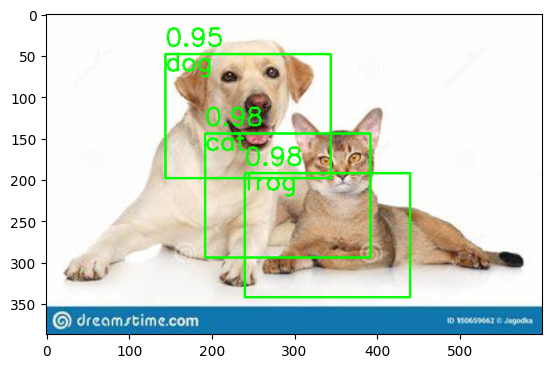

In [28]:
allclone = orig.copy()
for label in labels.keys():
    # clone the original image so that we can draw on it
    print("[INFO] showing results for '{}'".format(label))
    clone = orig.copy()

    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)

    # show the results *before* applying non-maxima suppression, then
    # clone the image again so we can display the results *after*
    # applying non-maxima suppression
    #plt.imshow(clone)
    #cv2.imshow("Before", clone)
    clone = orig.copy()

    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppressions(boxes, proba,0.1)
    print(boxes,proba)

    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        cv2.rectangle(allclone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y+30),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(clone, "{:.2f}".format(prob), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(allclone, label, (startX, y+30),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(allclone, "{:.2f}".format(prob), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # show the output after apply non-maxima suppression
    plt.imshow(clone)
    plt.imsave("./detetcted" + label + ".jpg", clone)
plt.imshow(allclone)
plt.imsave("./detected.jpg", allclone)
    #plt.imshow(clone)
    #plt.imsave("images/_res03.jpg", clone)
    #cv2.imshow("After", clone)
    #cv2.waitKey(0)
